In [1]:
import os
from os.path import join
from collections import defaultdict
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
root = "datasets"
member = os.listdir(root)

In [3]:
path = defaultdict(defaultdict)

for m in member:
    for char in os.listdir(join(root, m)):
        ls = sorted(os.listdir(join(root, m, char)))
        pls = [x for i, x in enumerate(ls) if i % 9 == 0]
        path[m][char] = list(map(lambda x: join(root, m, char, x), pls))

In [4]:
print(f'Who are the members? {list(path.keys())}\n')

for m in member:
    print(f'Member {m:5s} contributed {sum([len(x) for x in path[m].values()])} characters including classes: {list(path[m])}')

Who are the members? ['yeow', 'chua', 'oeh', 'chiew']

Member yeow  contributed 120 characters including classes: ['9', '0', '7', '6', '1', '8', '4', '3', '2', '5']
Member chua  contributed 120 characters including classes: ['9', '0', '7', '6', '1', '8', '4', '3', '2', '5']
Member oeh   contributed 120 characters including classes: ['9', '0', '7', '6', '1', '8', '4', '3', '2', '5']
Member chiew contributed 120 characters including classes: ['9', '0', '7', '6', '1', '8', '4', '3', '2', '5']


## Construct Dataset

In [130]:
class HandwritingDataset:
    def __init__(self, path=path):
        self.path = path
        self.id2cls = {}
        self.x = []
        self.y = []
        self.char = []
        for i, m in enumerate(path.keys()):
            self.id2cls[i] = m
            for char in path[m].keys():
                for c in path[m][char]:
                    self.x.append(np.expand_dims(cv2.imread(c, 0), -1))
                    self.y.append(i)
                    self.char.append(char)
                    
        self.x = torch.from_numpy(np.array(self.x))
        self.y = torch.tensor(self.y)
        self.char = np.array(self.char)
                    
        print(f'Constructed members\' handwriting dataset for {len(path.keys())} members with total {len(self.char)} characters')
        
    def get(self, cls: int, character: str):
        """ cls: 0 (yeow), 1 (chua) ..., character: 0, 1, 2, 3 ...
            return: a list of index self.__getitem__
        """
        cls_index = torch.where(self.y == cls)[0].numpy()
        char_index = np.where(self.char == character)[0]
        idx = cls_index[np.in1d(cls_index, char_index)]
        return idx
    
    def stratified_split(self, train_size=0.95):
        cls = self.get_cls()
        chars = self.get_chars()
        
        m = int(len(chars) * train_size)
        
        train = []
        test = []
        for i, (cls_idx, _cls) in enumerate(cls.items()):
            for j, char in enumerate(chars):
                train_index = self.get(cls_idx, char)[:m]
                test_index = self.get(cls_idx, char)[m:-1]
                train.extend(train_index)
                test.extend(test_index)
        
        # return (self.x[train], self.y[train]), (self.x[test], self.y[test])
        return (self.char[train], (self.x[train], self.y[train])), (self.char[test], (self.x[test], self.y[test]))
    
    def get_chars(self):
        return np.unique(self.char).tolist()
    
    def get_cls(self):
        return self.id2cls
    
    def get_class_label(self, cls):        
        return self.id2cls[cls.item()]
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.char[idx], (self.x[idx], self.y[idx])

class PrepForDataLoader(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset[0])
        
    def __getitem__(self, idx):
        char, (x, y) = self.dataset
        return char[idx], (x[idx], y[idx])

In [131]:
dataset = HandwritingDataset()

Constructed members' handwriting dataset for 4 members with total 480 characters


In [132]:
train_dataset, test_dataset = dataset.stratified_split()
train_dataset, test_dataset = PrepForDataLoader(train_dataset), PrepForDataLoader(test_dataset)

### Visualize one image for student 2 with character '5'

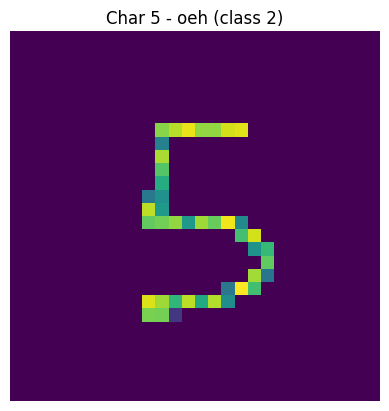

In [140]:
char, (x, y) = train_dataset[233]

plt.title(f'Char {char} - {dataset.get_class_label(y)} (class {y})')
plt.axis('off')
plt.imshow(x)

### Get Torch DataLoader

In [134]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, seed=seed)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, seed=seed)

## Analyse Dataset

### Visualize all images for all students characters

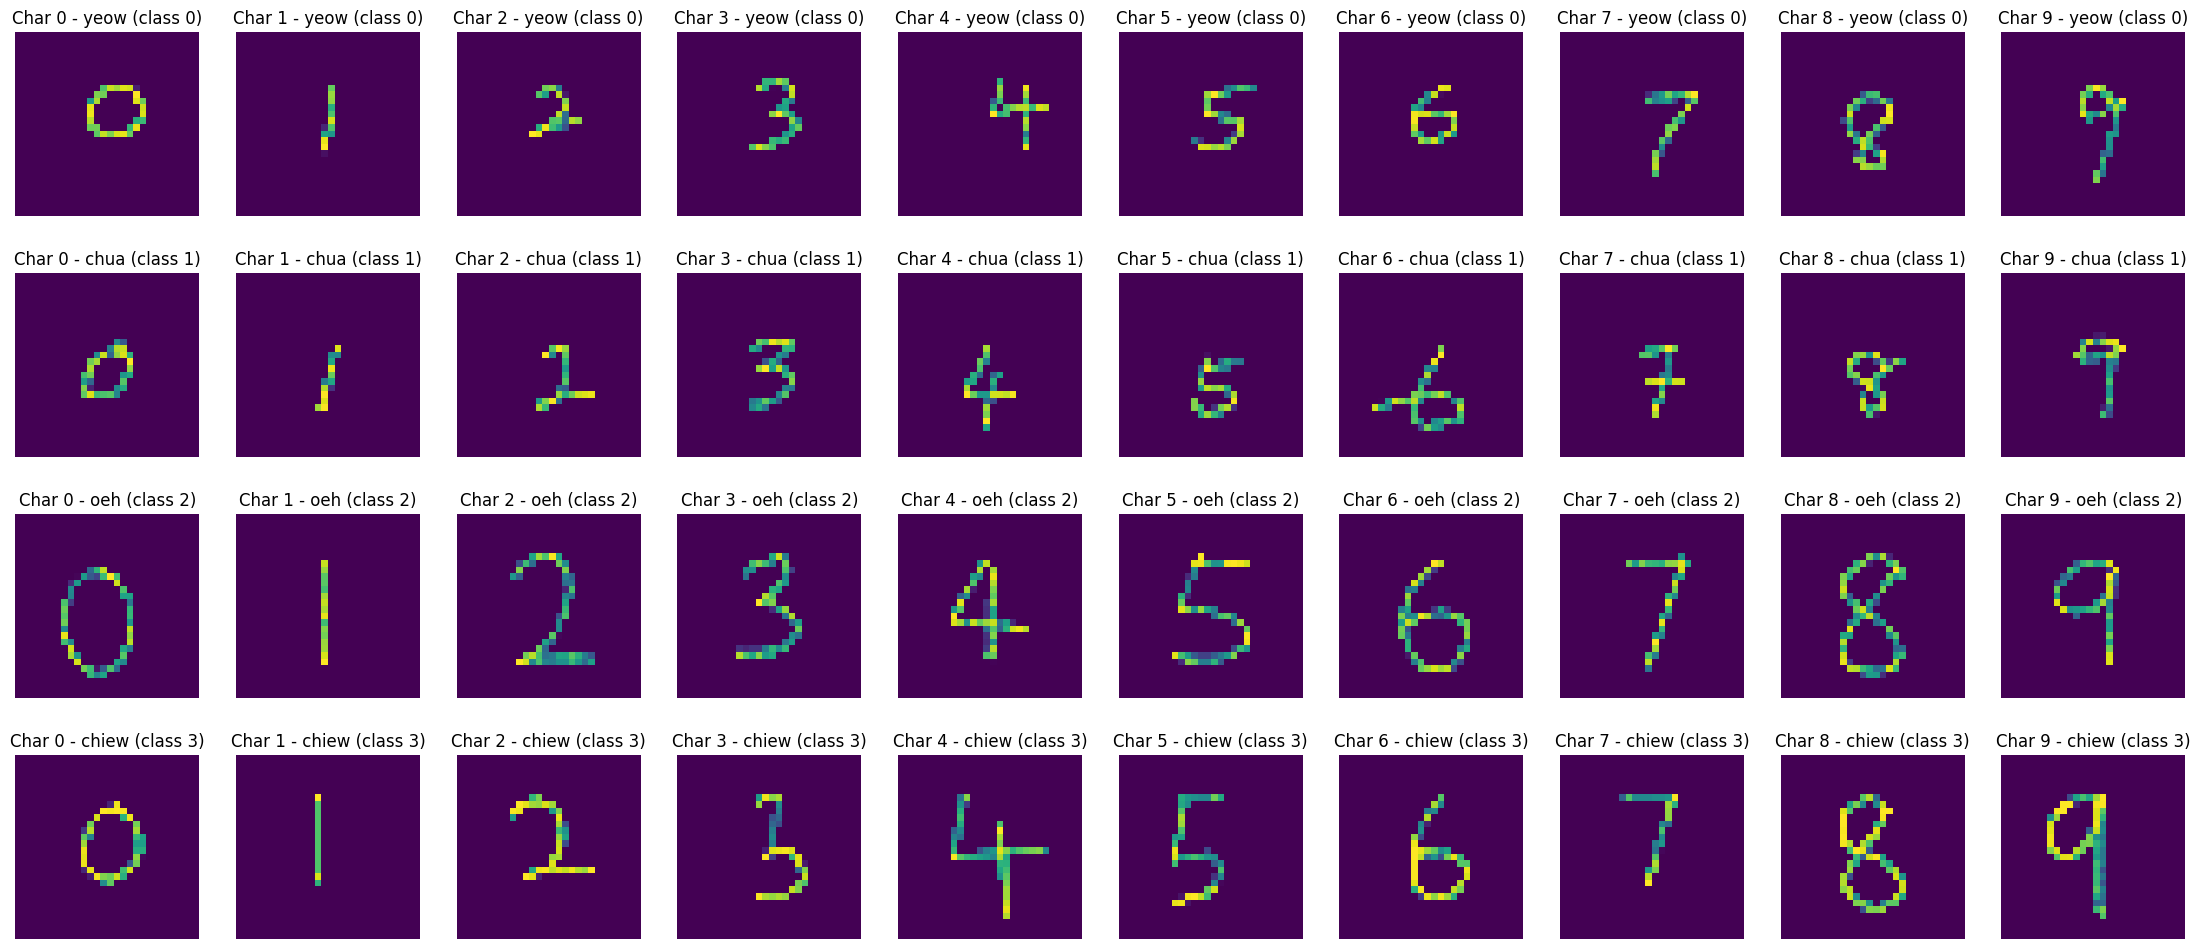

In [135]:
np.random.seed(seed)
randint = np.random.randint(0, 13)

cls = dataset.get_cls()
chars = dataset.get_chars()

def plot(char, x, y, subplot=None):
    if subplot: plt.subplot(*subplot)
    plt.title(f'Char {char} - {dataset.get_class_label(y)} (class {y})')
    plt.axis('off')
    plt.imshow(x)

plt.figure(figsize=(28, 12))
for i, (cls_idx, _cls) in enumerate(cls.items()):
    for j, char in enumerate(chars):
        index = dataset.get(cls_idx, char)[randint]
        ch, (x, y) = dataset[index]
        plot(ch, x, y, (len(cls), len(chars), i * len(chars) + j + 1))

## Train Model

In [141]:
from models.resnet import ResNet50

In [142]:
lr = 3e-4
epochs = 100

net = ResNet50(4, channels=1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

Training Done
